# Advanced Lane Lines

*The goals / steps of this project are the following:*

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In this writeup document, the chapters are the goals with the same numbering as noted above. The code is also included and the images are direct output of the code.

*Most of the code is based on the code from the lessons.*

## 0. Imports

Imports of all used libraries.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

np.set_printoptions(threshold=1500)

import glob

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

## 1. Calibration

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function.

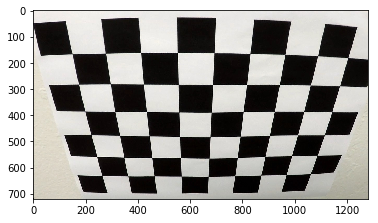

In [2]:
%matplotlib inline
img = mpimg.imread("camera_cal/calibration2.jpg")

plt.imshow(img)

In [3]:
objpoints = [] # 3D points in real world
imgpoints = [] # 2D points in 2D image represenataion of real world

# Generate all grid points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 

In [4]:
# Import all calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

# Loop through all calibration images
for cal_fname in cal_images:
    # Read each image
    cal_img = cv2.imread(cal_fname)

    # Convert to grayscale
    gray = cv2.cvtColor(cal_img, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners found, add points to arrays
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw the corners
        img_corners = cv2.drawChessboardCorners(cal_img, (9,6), corners, ret)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## 2. Undistortion

I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

In [5]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

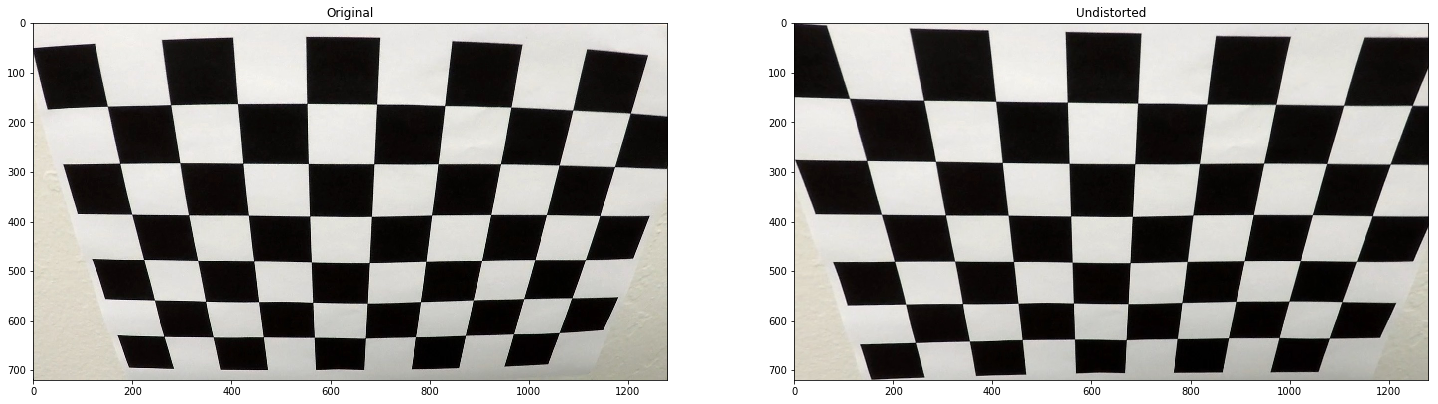

In [6]:
img = mpimg.imread("camera_cal/calibration2.jpg")

f, axarr = plt.subplots(1, 2, figsize=(25,25))
axarr[0].set_title('Original')
axarr[0].imshow(img)
axarr[1].set_title('Undistorted')
axarr[1].imshow(undistort(img))

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one: 

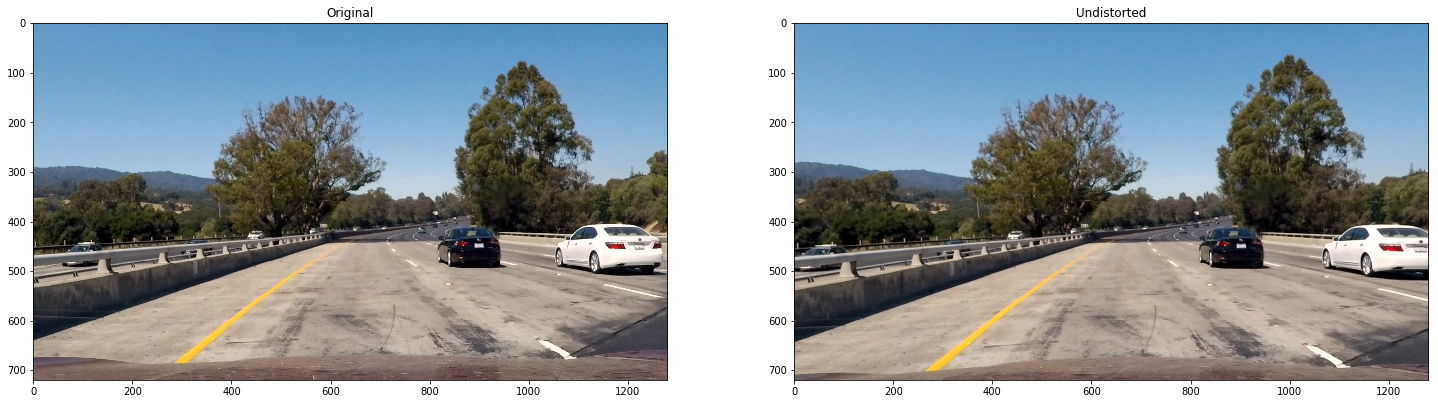

In [7]:
img = mpimg.imread("test_images/test1.jpg")

f, axarr = plt.subplots(1, 2, figsize=(25,25))
axarr[0].set_title('Original')
axarr[0].imshow(img)
axarr[1].set_title('Undistorted')
axarr[1].imshow(undistort(img))

## 3. Perspective transform

The code for my perspective transform includes a function called `change_perspective()`, which appears in the last lines of the cell below.  The `change_perspective()` function takes as inputs an image (`img`). I chose the hardcode the source and destination points in the following manner:

In [8]:
src = np.float32([
    [580, 460], # LT
    [703, 460], # RT
    [205, 720], # LB
    [1110, 720], # RB
])

dest = np.float32([
    [320, 0], # LT
    [960, 0], # RT
    [320, 720], # LB
    [960, 720], # RB
])

M = cv2.getPerspectiveTransform(src, dest)
Minv = cv2.getPerspectiveTransform(dest, src)

# Get image coordinates as source for perspective change
def change_perspective(img):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

## 4. Threshold

I used a combination of color and gradient thresholds to generate a binary image, like proposed in the lessons. I combined the following thresholds to make the binary image:
- Gradient sobel threshold
- Sobel maginitude threshold
- Sobel directional threshold
- Selection of S-color channel from HLS color space

All these functions are added to the `pipeline`, which can be found in some cells below.

### Sobel

In [9]:
# Inspired by lessons of this project
def gradient_sobel_threshold(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

def combine_thresholds(gradx_bin, grady_bin, mag_bin, dir_bin):
    combined = np.zeros_like(dir_bin)
    combined[((gradx_bin == 1) & (grady_bin == 1)) | ((mag_bin == 1) & (dir_bin == 1))] = 1
    return combined

### Color

In [10]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output



### Combining gradient and color

In [11]:
def combine_binary(sxbinary, s_binary):
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

## 5. Find lines

In the `find_lines()` function, I managed to find the lines using the binary image. The function works as follows:
1. Split the image in two, and find the lines at the base (bottom of the screen) using the peaks of the histogram. **Note** that I've got rid of the 200 pixels on both sides, because at the base there will never be a lane-line (only when you cross those lines, but that is not happening in this video).
2. In case you search the line for the first time: use sliding windows to measure the slope of the line for every X pixels (in this case X is height/9). Get those 'points' and add them to `left_lane_inds` and `right_lane_inds` lists.
3. Fit a line using these indexes.
4. In case you have the indexes of last iteration, use them in stead of the sliding window to fit a line.

In [31]:
def find_lines(binary_warped, left_line, right_line):
    if not left_line.detected or not right_line.detected:
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)

        ## Set right/left margin to 200, base cannot be much more to the side of the road
        leftx_base = np.argmax(histogram[200:midpoint]) + 200
        rightx_base = np.argmax(histogram[midpoint:1080]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
               
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

    else:
        # Find pixels in same region as previous run
        
        left_fit = left_line.current_fit
        right_fit = right_line.current_fit 
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
            left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
            left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
            right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
            right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fill the line-objects
    left_line.recent_xfitted.append(left_fitx)
    right_line.recent_xfitted.append(right_fitx)

    left_line.current_fit = left_fit
    right_line.current_fit = right_fit

    left_line.allx = leftx
    left_line.ally = lefty
    right_line.allx = rightx
    right_line.ally = righty

    left_line.detected = True
    right_line.detected = True
   

## 6. Calculate offset and curve

### Offset calculations

With the assumption of the US lane with of 3.7 meters, use the warped image to calculate the offset to the center.

In [14]:
US_lane_width = 3.7 # Meters

def calculate_offset_in_m(warp, left_line, right_line):
    left_pixels = sum(warp[warp.shape[0]-1,0:int(warp.shape[1]/2)-1,1] > 1)
    right_pixels = sum(warp[warp.shape[0]-1,int(warp.shape[1]/2)-1:,1] > 1)
    
    total_pixels = left_pixels + right_pixels
    
    meter_per_pixel = US_lane_width / total_pixels
        
    left_line.line_base_pos = left_pixels * meter_per_pixel
    right_line.line_base_pos = right_pixels * meter_per_pixel
       

### Calculate curvature

Calculate the curvature by calculating the curve of both lines in radians and then transform it into meters.

In [15]:
def calculate_curvature(left_line, right_line):
    left_fit = left_line.current_fit 
    right_fit = right_line.current_fit
    
    leftx = left_line.allx 
    lefty = left_line.ally 
    rightx = right_line.allx 
    righty = right_line.ally 
    
    y_eval = 720
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = US_lane_width/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
   
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad

## 7. Draw lane field

Draw a polygon using the lines and then warp this drawing back onto the original image using a certain opacity.

In [16]:
def draw_lane_field(image, warped, left_line, right_line):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    left_fitx = left_line.recent_xfitted[-1]
    right_fitx = right_line.recent_xfitted[-1]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result, newwarp

## 8. Visualization of all steps

In this chapter every step from above is visualized. All the test images are taken through the pipeline and have a step-by-step visualization. The exported video can be found in the Github repo: https://github.com/johnciocoiu/udacity-nd-self-driving-car-project-4/blob/master/output_images/project_video.mp4

In [17]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
#         self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
#         self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in meters
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
#         self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    

## Pipeline

- Undistort
- Change perspective
- Gradient (Sobel)
- Color: convert to HLS and use S-channel
- Combine gradient and color
- Find lines
- Put text on image
- Draw lane field

In [34]:
def process_image(img, left_line, right_line):
    undist_image = undistort(img)
    perspective_image = change_perspective(undist_image)
    
    # Gradient
    gradx_bin = gradient_sobel_threshold(perspective_image, 'x', 20, 100)
    grady_bin = gradient_sobel_threshold(perspective_image, 'x', 20, 100)
    mag_bin = mag_thresh(perspective_image, 3, (30, 100))
    dir_bin = dir_threshold(perspective_image, 3, (0.7, 1.3))
    sobel_bin = combine_thresholds(gradx_bin, grady_bin, mag_bin, dir_bin)
    
    # Color
    hls_binary = hls_select(perspective_image, thresh=(170, 255))
    
    # Color and gradient
    grad_color_bin = combine_binary(sobel_bin, hls_binary)
    
    find_lines(grad_color_bin, left_line, right_line)
    
    drawed_field, warp = draw_lane_field(undist_image, grad_color_bin, left_line, right_line)
    
    calculate_offset_in_m(warp, left_line, right_line)
    offset = left_line.line_base_pos - ((left_line.line_base_pos + right_line.line_base_pos)/2)
    
    calculate_curvature(left_line, right_line)
    
    mean_curve = np.mean([left_line.radius_of_curvature, right_line.radius_of_curvature])
    mean_curve = 0.0 if mean_curve > 1200 else mean_curve
     
    font = cv2.FONT_HERSHEY_SIMPLEX
    result_offset = cv2.putText(drawed_field, str('Offset: {:.2f}m'.format(offset)) ,(20,70), font, 2, (255,255,255),5,cv2.LINE_AA)
    result_curve = cv2.putText(drawed_field, str('Curve: {:.2f}m'.format(mean_curve)) ,(20,140), font, 2, (255,255,255),5,cv2.LINE_AA)
    
    return undist_image, perspective_image, sobel_bin, hls_binary, grad_color_bin, drawed_field

## Pipeline on test images

Here you will see the pipeline used to make the test-images. Every step is showed as image.

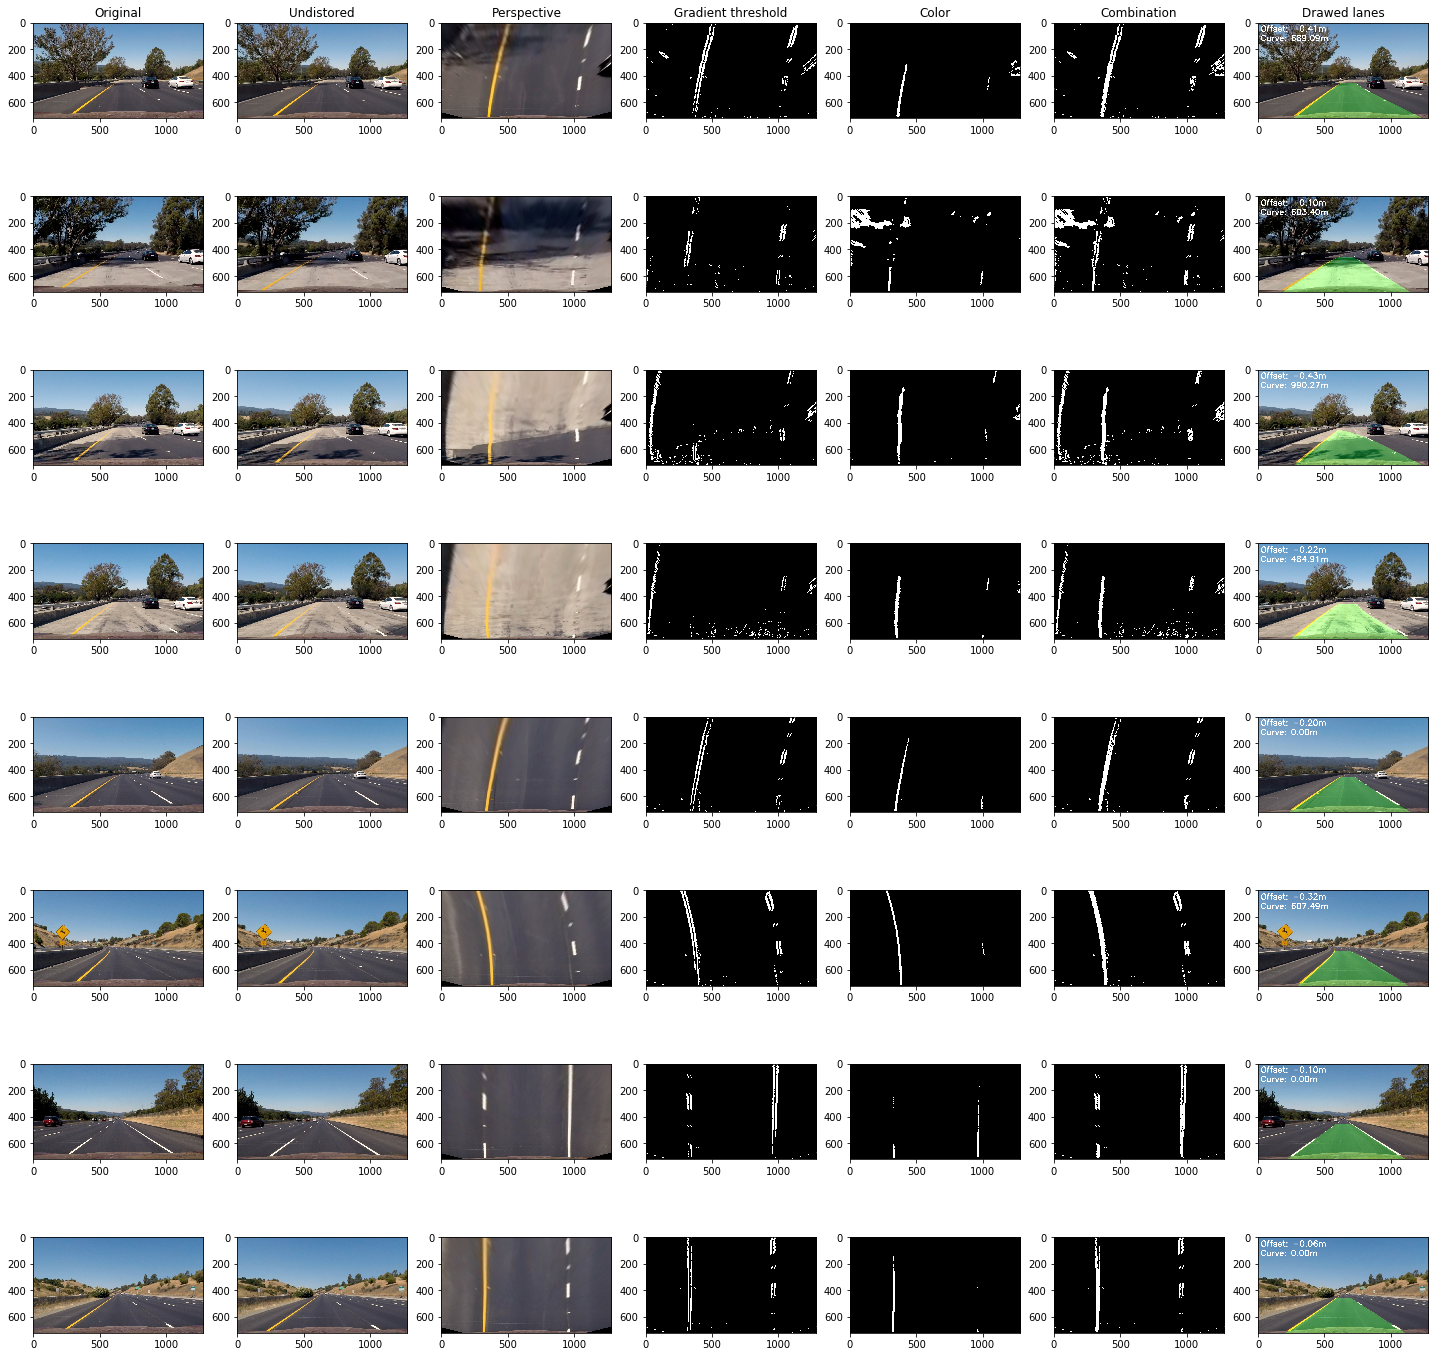

In [35]:
test_images = glob.glob('test_images/*.jpg')

f, axarr = plt.subplots(len(test_images), 7, figsize=(25,25))

for i, test_fname in enumerate(test_images):
    test_image = mpimg.imread(test_fname)
    
    # Reinitialize lines every run because er is nothing to learn from previous one
    left_line = Line()
    right_line = Line()

    undist, persp, sobel, hls, grad_color, drawed = process_image(test_image, left_line, right_line)

    if i == 0:
        axarr[i,0].set_title('Original')
        axarr[i,1].set_title('Undistored')
        axarr[i,2].set_title('Perspective')
        axarr[i,3].set_title('Gradient threshold')
        axarr[i,4].set_title('Color')
        axarr[i,5].set_title('Combination')
        axarr[i,6].set_title('Drawed lanes')
    
    axarr[i,0].imshow(test_image)
    axarr[i,1].imshow(undist)
    axarr[i,2].imshow(persp)
    axarr[i,3].imshow(sobel, cmap='gray')
    axarr[i,4].imshow(hls, cmap='gray')
    axarr[i,5].imshow(grad_color, cmap='gray')
    axarr[i,6].imshow(drawed)
    
    mpimg.imsave('output_images/'+test_fname.split('/')[1], drawed)

# Pipeline on video

Use the pipeline to create the lane on the video.

In [36]:
# Rewrite image to frame processing

def process_frame(image):
    undist, persp, sobel, hls, grad_color, drawed = process_image(image, left_line, right_line)
    return drawed

In [37]:
left_line = Line()
right_line = Line()

output = 'output_images/project_video.mp4'
clip = VideoFileClip("project_video.mp4")
project_clip = clip.fl_image(process_frame)
%time project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [04:07<00:00,  5.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 15min 27s, sys: 9.78 s, total: 15min 37s
Wall time: 4min 7s


## Possible improvements

1. Now just the previous line-fit is used to draw the lines, this could be improved using more then just one previous frame. 
- Use a sanity check to see whether the fitted lines are realistic, if not, reset the `line.detected` and calculate the line again without any knowledge or with the knowledge of the fit of even more frames ago.
- The distance between both lines could be used, because this will always be 3.7 meters (conv to pixels) and won't change fast between frames.
- The car stays inside one lane, when changing lanes, the system needs to be improved.
- Separate lane-lines for every detection. In case one line is detected and the other isn't, you almost 'know' where that other in will be.

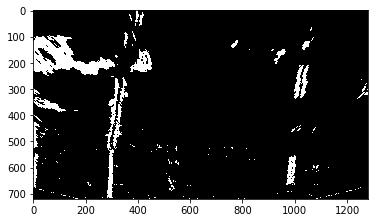

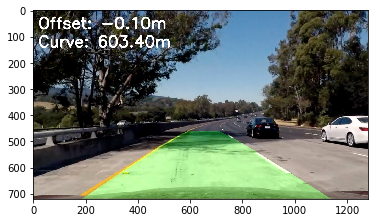

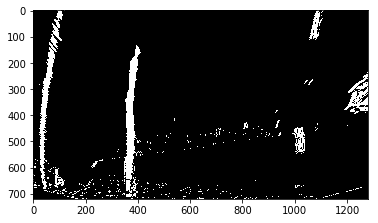

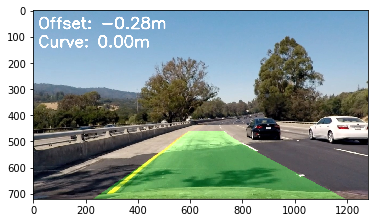

In [33]:
## JUST A TEST FUNCTION, NOTHING MORE

%matplotlib inline

left_line = Line()
right_line = Line()

test_image = mpimg.imread('test_images/test5.jpg')

undist, persp, sobel, hls, grad_color, drawed = process_image(test_image, left_line, right_line)

plt.figure()
plt.imshow(grad_color, cmap='gray')
plt.figure()
plt.imshow(drawed)

test_image = mpimg.imread('test_images/test4.jpg')

undist, persp, sobel, hls, grad_color, drawed = process_image(test_image, left_line, right_line)

plt.figure()
plt.imshow(grad_color, cmap='gray')
plt.figure()
plt.imshow(drawed)